In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="ticks", palette="mako")

In [3]:
# Reading short imputed master dataframe
master_df = pd.read_csv("data/2016_2021_master_df_short_imputed.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

,STATION,PM 2.5,MISSING,MISSING_SEQ,MISSING_SAMPLE
DATE_PST,,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0,0


(228056, 5)


## Imputation of short sequences (2h, 6h]
* Short sequences with 3 to 6 subsequent data points missing
* FFT
* LSTM

In [4]:
# Experimentation subsets
# Vancouver Clark Drive station
subsets_clark = {}
# 1 Month no major anomaly
subsets_clark["Vancouver_Clark_Drive_PM25_2-2016"] = master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"].loc[
    datetime(2016, 2, 1):datetime(2016, 3, 1), ["PM 2.5"]]
# 3 Months with major anomaly
subsets_clark["Vancouver_Clark_Drive_PM25_7-2018_to_9-2018"] = master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"].loc[
    datetime(2018, 7, 1):datetime(2018, 10, 1), ["PM 2.5"]]
# 12 Months with major anomaly
subsets_clark["Vancouver_Clark_Drive_2020"] = master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"].loc[
    datetime(2020, 1, 1):datetime(2021, 1, 1), ["PM 2.5"]]
# Complete series
subsets_clark["Vancouver_Clark_Drive_PM25"] = master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"][["PM 2.5"]]

# North Vancouver Mahon Park station
subsets_mahon = {}
# 1 Month no major anomaly
subsets_mahon["North_Vancouver_Mahon_Park_PM25_2-2017"] = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"].loc[
    datetime(2017, 2, 1):datetime(2017, 3, 1), ["PM 2.5"]]
# 3 Months with major anomaly
subsets_mahon["North_Vancouver_Mahon_Park_PM25_7-2020_to_9-2020"] = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"].loc[
    datetime(2020, 7, 1):datetime(2020, 10, 1), ["PM 2.5"]]
# 12 Months with major anomaly
subsets_mahon["North_Vancouver_Mahon_Park_PM25_2021"] = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"].loc[
    datetime(2021, 1, 1):datetime(2022, 1, 1), ["PM 2.5"]]
# Complete series
subsets_mahon["North_Vancouver_Mahon_Park_PM25"] = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"][["PM 2.5"]]

In [5]:
from darts import TimeSeries
from darts.models import FFT
from darts.metrics import mae, rmse

# Darts timeseries64
for subset in subsets_clark:
    subsets_clark[subset] = TimeSeries.from_dataframe(subsets_clark[subset])

for subset in subsets_mahon:
    subsets_mahon[subset] = TimeSeries.from_dataframe(subsets_mahon[subset])

/home/erich/projects/Air-We-Breath/.awb/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Auxiliar plotting function
def dart_plot(train, val, pred=None):
    plt.figure(figsize=(12, 2.5))
    train.plot(label="training")
    val.plot(label="validation", linewidth=1)
    if pred:
        pred.plot(label="predict", linewidth=1.5, color = "darkorange")
        plt.title(f"MAE: {mae(pred, val):.3f} | RMSE: {rmse(pred, val):.3f}", fontsize=10)
        plt.suptitle(f"{subset}".replace("_PM25", "").replace("_", " "), fontweight="bold", fontsize=11, y=1.04)
    else:
        plt.title(f"{subset}".replace("_PM25", "").replace("_", " "), fontweight="bold", fontsize=11)
    plt.legend()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel("PM 2.5", fontsize=11)
    sns.despine()
    plt.show()

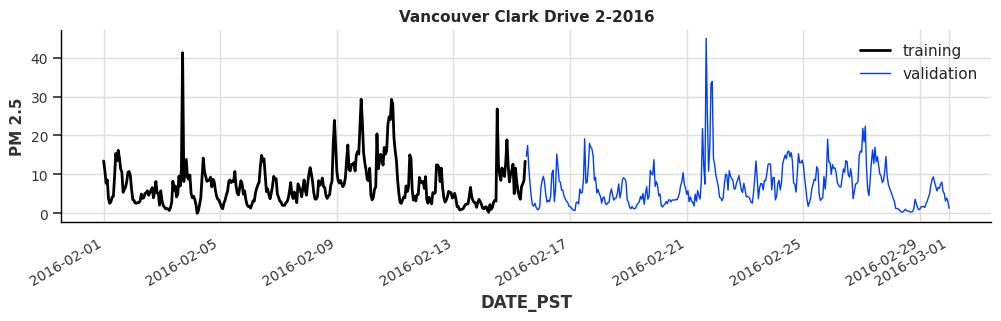

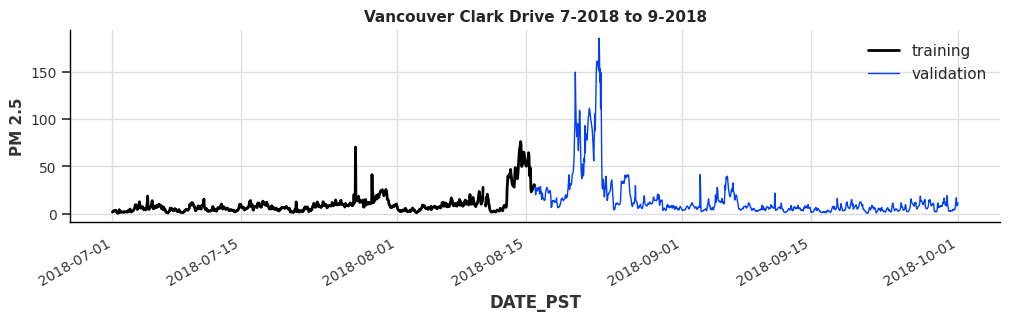

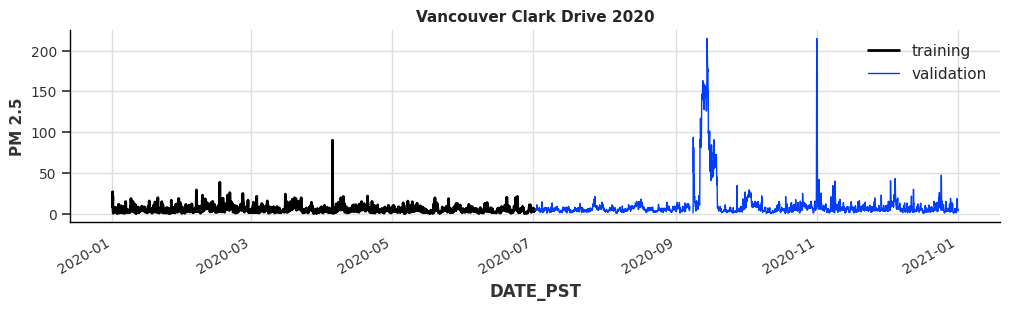

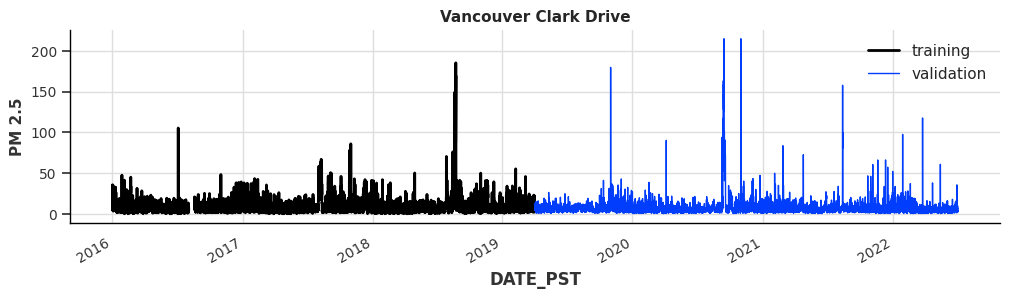

In [7]:
# Training and Validation sets Clark Drive
for subset in subsets_clark:
    series = subsets_clark[subset]
    train, val = series.split_before(0.5)

    # Darts training and validation plot
    dart_plot(train, val)

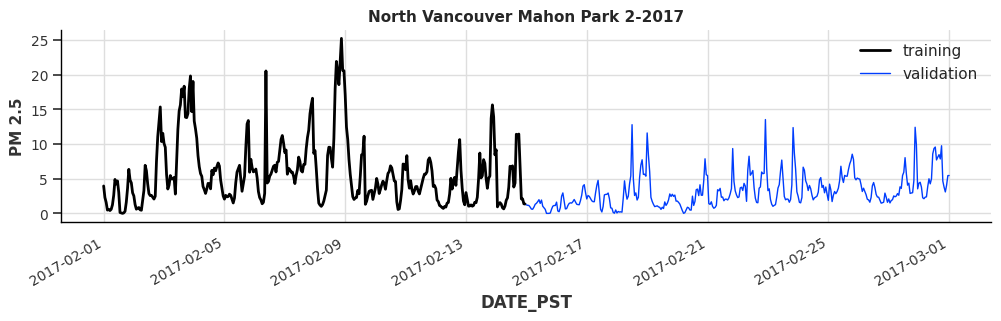

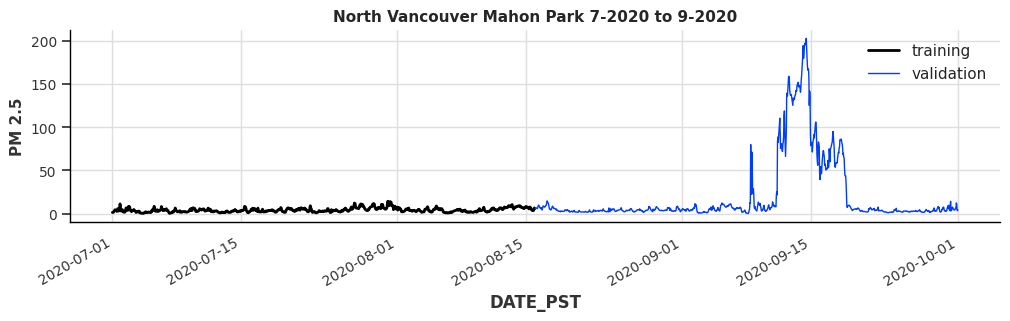

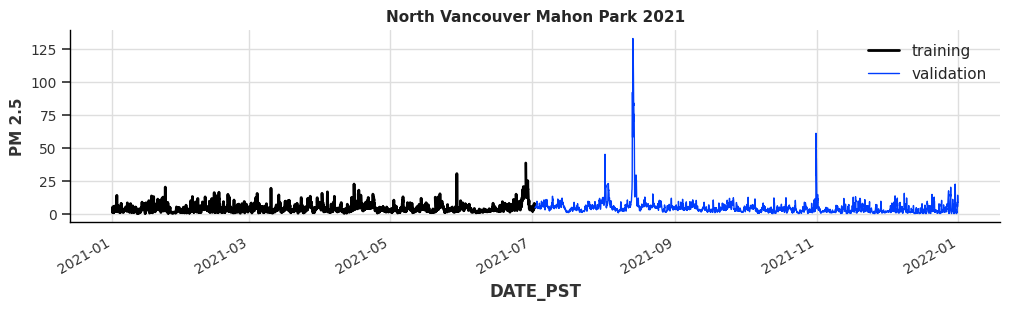

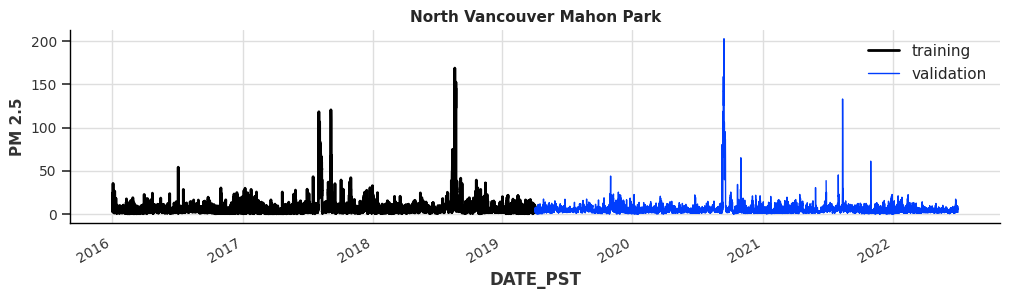

In [8]:
# Training and Validation sets Mahon Park
for subset in subsets_mahon:
    series = subsets_mahon[subset]
    train, val = series.split_before(0.5)

    # Darts training and validation plot
    dart_plot(train, val)

## Fast Fourier Transform
* Base model without amplitude filtering
* Base model filtering low-amplitude waves

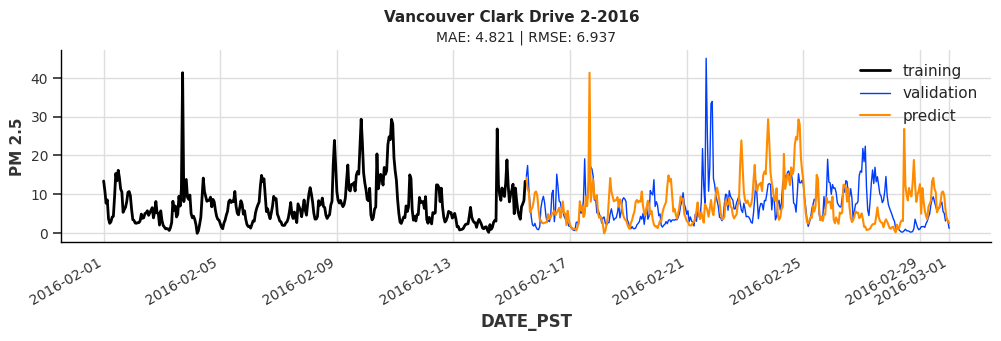

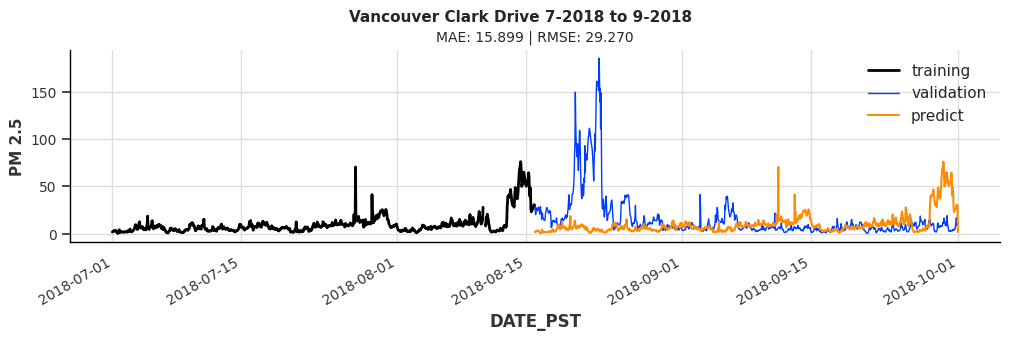

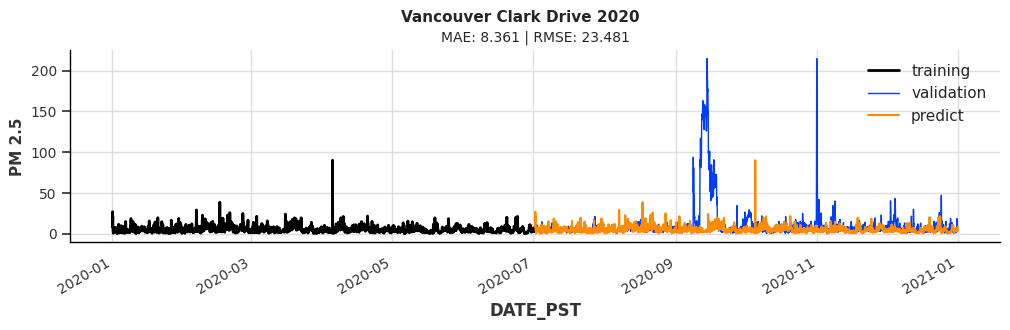

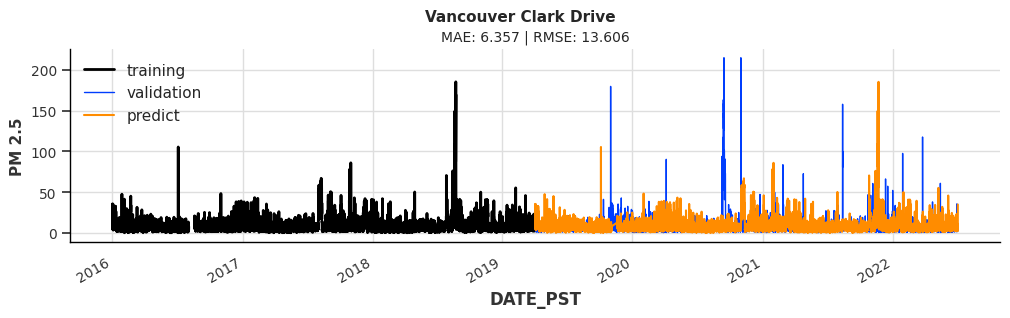

In [9]:
# Fast Fourier Transform without amplitude filtering
fft_model = FFT(nr_freqs_to_keep=None)

for subset in subsets_clark:
    # Train test split
    series = subsets_clark[subset]
    train, val = series.split_before(0.5)

    fft_model.fit(train)
    pred_val = fft_model.predict(len(val))

    dart_plot(train, val, pred_val)

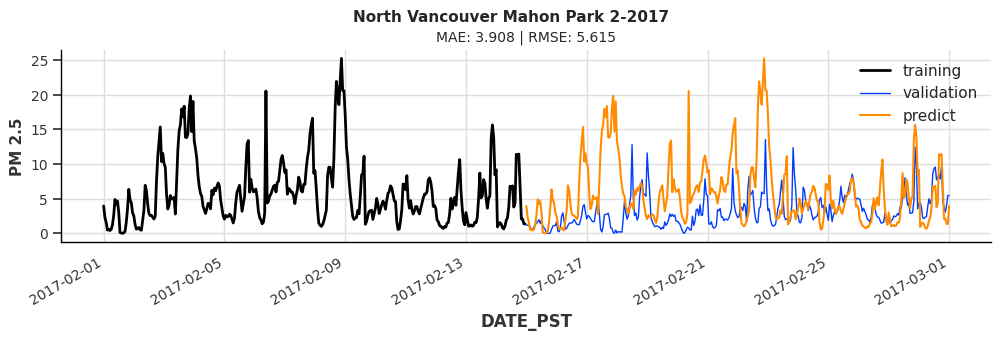

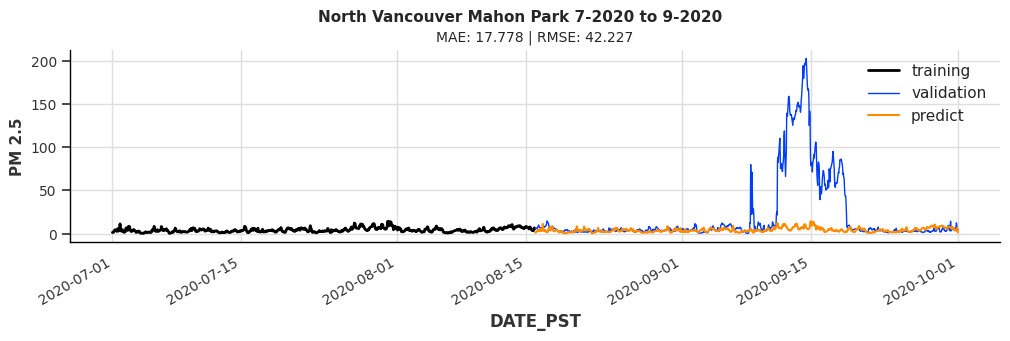

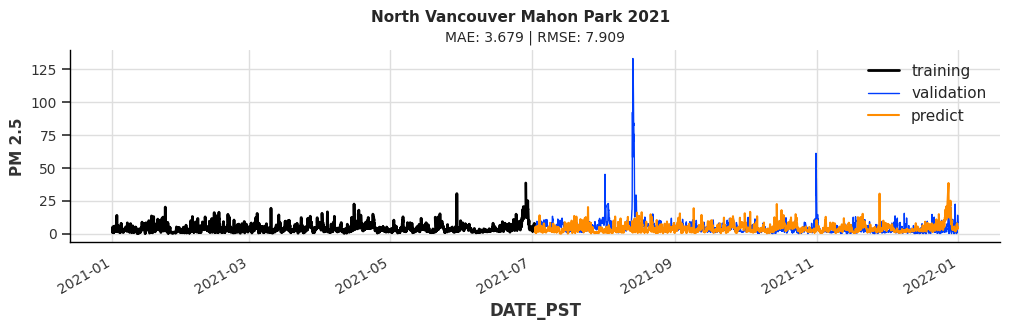

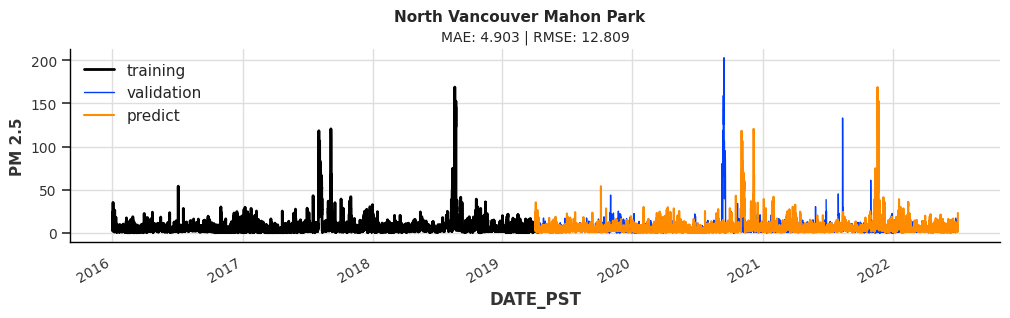

In [10]:
# Fast Fourier Transform without amplitude filtering
fft_model = FFT(nr_freqs_to_keep=None)

for subset in subsets_mahon:
    # Train test split
    series = subsets_mahon[subset]
    train, val = series.split_before(0.5)

    fft_model.fit(train)
    pred_val = fft_model.predict(len(val))

    dart_plot(train, val, pred_val)

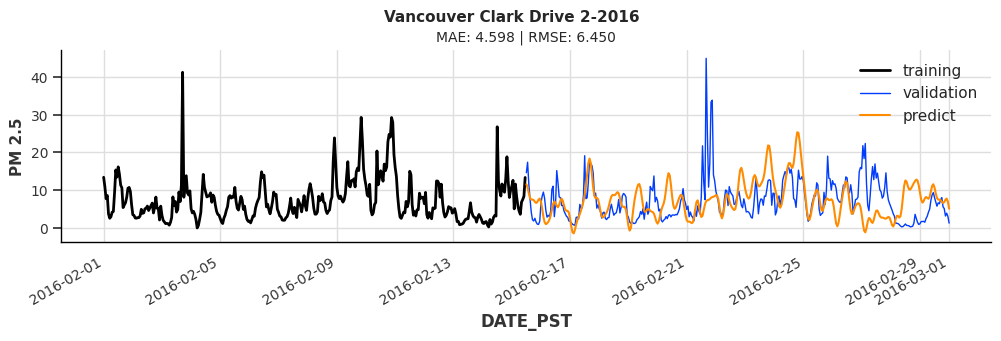

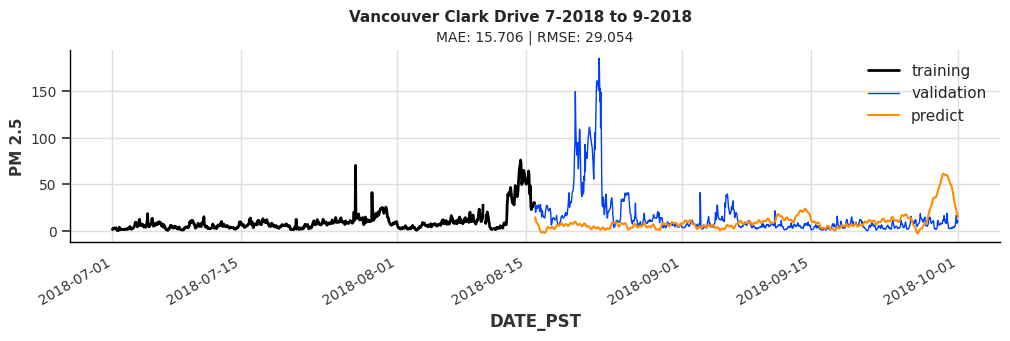

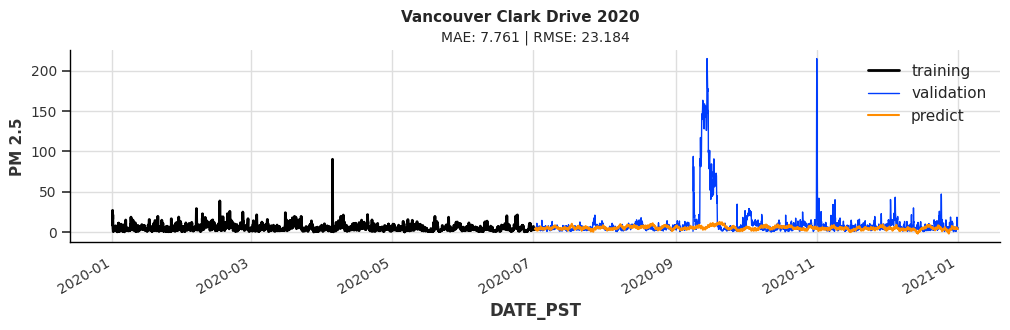

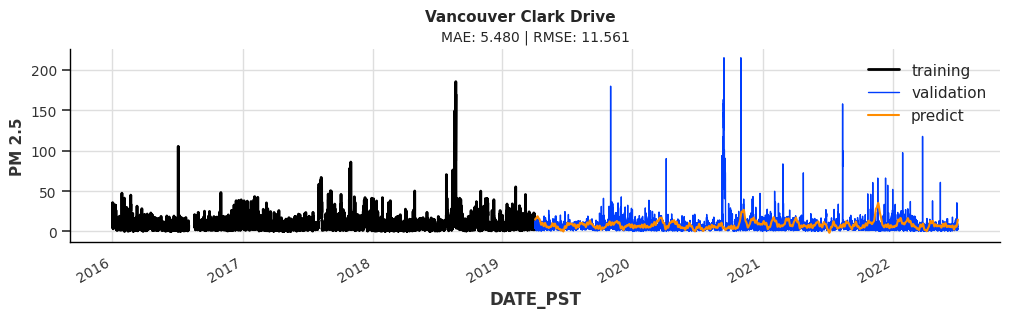

In [11]:
# Fast Fourier Transform filtering low-amplitude waves
fft_model = FFT(nr_freqs_to_keep=50)

for subset in subsets_clark:
    # Train test split
    series = subsets_clark[subset]
    train, val = series.split_before(0.5)

    fft_model.fit(train)
    pred_val = fft_model.predict(len(val))

    dart_plot(train, val, pred_val)

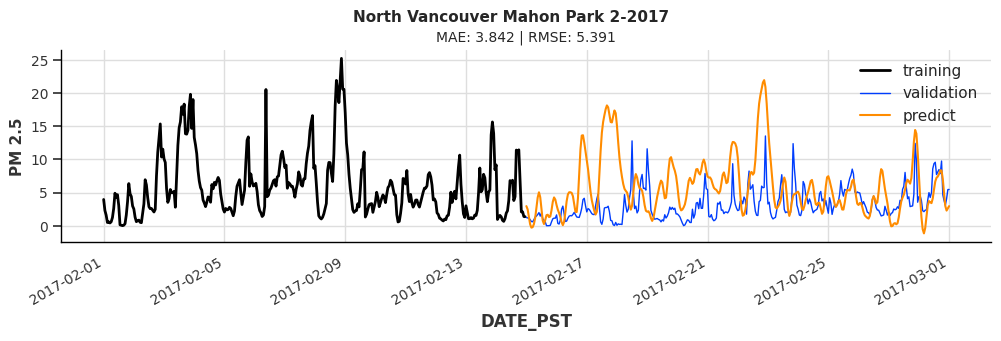

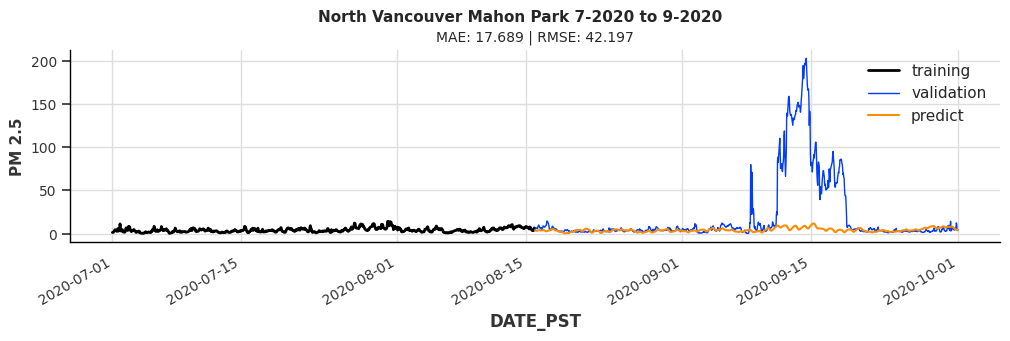

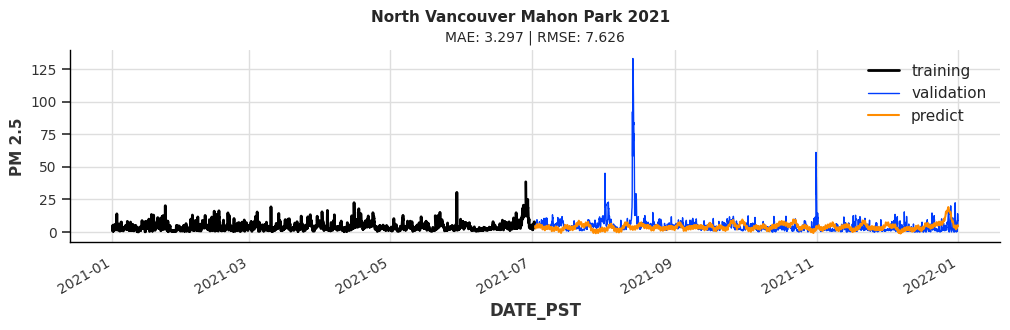

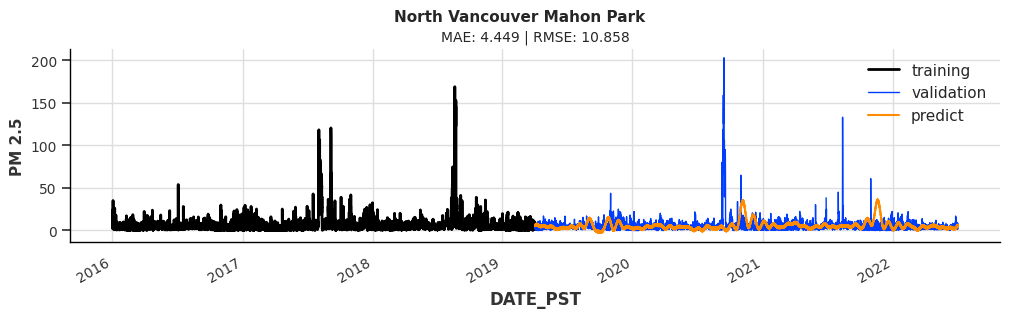

In [12]:
# Fast Fourier Transform filtering low-amplitude waves
fft_model = FFT(nr_freqs_to_keep=50)

for subset in subsets_mahon:
    # Train test split
    series = subsets_mahon[subset]
    train, val = series.split_before(0.5)

    fft_model.fit(train)
    pred_val = fft_model.predict(len(val))

    dart_plot(train, val, pred_val)

## LSTM
* Univariate LSTM
* LSTM with dateparts covariates

In [14]:
# LSTM with datepart covariates
from darts.models import RNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
# from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler

# LSTM Class
class LSTM:
    def __init__(
        self,
        training_length: int,
        input_chunk_length: int,
        hidden_dim: int,
        n_epochs: int,
        dropout: float = 0.0,
        batch_size: int = 16,
        lr: float = 1e-3,
        save_checkpoints: bool = True,
    ):
        self.hidden_dim=hidden_dim,
        self.dropout=dropout,
        self.batch_size=batch_size,
        self.n_epochs=n_epochs,
        self.lr=lr,
        self.training_length=training_length,
        self.input_chunk_length=input_chunk_length,
        self.save_checkpoints=save_checkpoints
    
    def build_model(self):
        model = RNNModel(
            model="LSTM",
            hidden_dim=self.hidden_dim,
            dropout=self.dropout,
            batch_size=self.batch_size,
            n_epochs=self.n_epochs,
            optimizer_kwargs={"lr": self.lr},
            model_name="LSTM",
            log_tensorboard=True,
            random_state=123,
            training_length=self.training_length,
            input_chunk_length=self.input_chunk_length,
            force_reset=True,
            save_checkpoints=True,
        )
        return model

2022-11-05 02:07:09 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: False
2022-11-05 02:07:09 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-05 02:07:09 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-05 02:07:09 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-05 02:07:10 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 14.8 K
4 | V             | Linear           | 51    
---------------------------------------------------
14.9 K    Trainable params
0         Non-trainable params
14.9 K    Total params
0.119     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 40/40 [00:00<00:00, 69.73it/s, loss=0.00605, v_num=logs, train_loss=0.00405, val_loss=0.00786]

2022-11-05 02:08:16 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.52it/s]


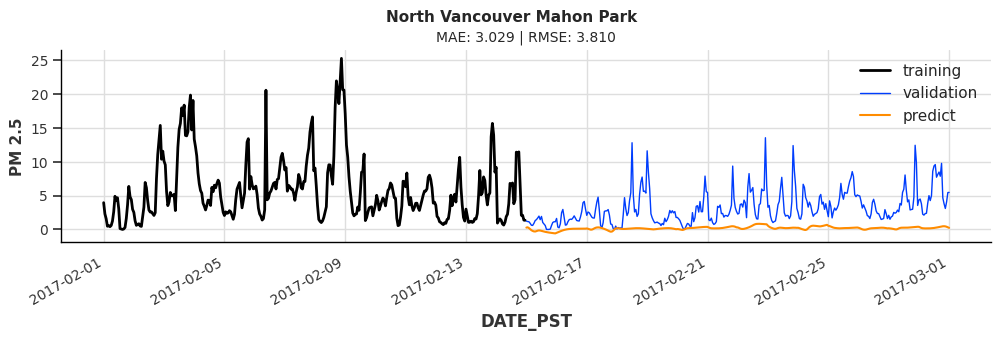

In [15]:
# LSTM
# Train test split
series = subsets_mahon["North_Vancouver_Mahon_Park_PM25_2-2017"]
train, val = series.split_before(0.5)

# Normalizing
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

## Creating month, year, and day-of-week covariates
# Year covariates
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(),
                    freq=series.freq_str,
                    periods=len(series)),
    attribute="year",
    one_hot=False,
)
# Scaling year covariates
year_series = Scaler().fit_transform(year_series)

# Month covariates
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)

# Weekday covariates
weekday_series = datetime_attribute_timeseries(
    year_series, attribute="weekday", one_hot=True
)

# Hour covariates
hour_series = datetime_attribute_timeseries(
    year_series, attribute="hour", one_hot=False
)
# Scaling hour covariates
hour_series = Scaler().fit_transform(hour_series)

# Stacking and splitting covariates
covariates = year_series.stack(month_series)
covariates = covariates.stack(weekday_series)
covariates = covariates.stack(hour_series)
cov_train, cov_val = covariates.split_before(0.5)

# lstm_model = LSTM(
#     training_length=20,
#     input_chunk_length=14,
#     hidden_dim=20,
#     n_epochs=300,
# )
# model = lstm_model.build_model()
# model.fit(
#     train_transformed,
#     # future_covariates=covariates,
#     val_series=val_transformed,
#     # val_future_covariates=covariates,
#     verbose=True
# )

my_model = RNNModel(
model="LSTM",
hidden_dim=50,
dropout=0,
batch_size=16,
n_epochs=100,
optimizer_kwargs={"lr": 5e-4},
model_name="LSTM",
log_tensorboard=True,
random_state=42,
training_length=20,
input_chunk_length=14,
force_reset=True,
save_checkpoints=True,
)

my_model.fit(
train_transformed,
future_covariates=covariates,
val_series=val_transformed,
val_future_covariates=covariates,
verbose=True,
)

pred_val = my_model.predict(n=len(val), future_covariates=covariates)
dart_plot(train, val, pred_val)